# **Reinforcement Learning Project**

**Kalliopi - Christina Despotidou**

**Student ID: 7115122400016**

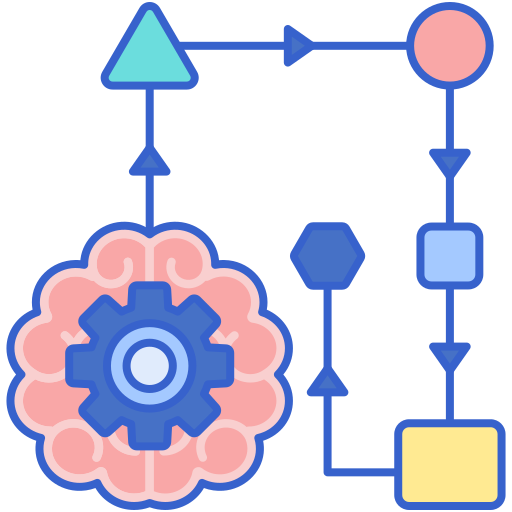

Install Required Libraries

In [4]:
pip install gym torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Import Libraries

In [5]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# **QUESTION 2: DQN**

Define the DQN Network

Create a neural network to approximate the Q-value function:

In [6]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


Define the Replay Buffer

The replay buffer stores experiences (state, action, reward, next state, done) for training:



In [7]:
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

Hyperparameters

In [8]:
learning_rate = 0.001
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
memory_capacity = 10000
batch_size = 32
target_update = 10
num_episodes = 500

Define the DQN Agent


The agent interacts with the environment and learns from experiences:

In [9]:
class DQNAgent:
    def __init__(self, state_dim, n_actions, memory_capacity=10000, batch_size=32, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, learning_rate=0.001, target_update=10):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update

        # Networks
        self.policy_net = DQN(state_dim, n_actions)
        self.target_net = DQN(state_dim, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(memory_capacity)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)  # Random action
        with torch.no_grad():
            return self.policy_net(state).argmax().item()  # Greedy action

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from memory
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

        # Convert to tensors
        batch_state = torch.cat(batch_state)
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
        batch_next_state = torch.cat(batch_next_state)
        batch_done = torch.tensor(batch_done, dtype=torch.float32)

        # Compute Q(s, a) with policy network
        current_q_values = self.policy_net(batch_state).gather(1, batch_action)

        # Compute target Q values with target network
        next_q_values = self.target_net(batch_next_state).max(1)[0].detach()
        target_q_values = batch_reward + (self.gamma * next_q_values * (1 - batch_done))

        # Compute loss and optimize
        loss = nn.functional.mse_loss(current_q_values, target_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

Train the Agent

Train the agent on the CartPole-v1 environment:

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-11-08924d9442ee>:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/gym/utils/p

Episode 1, Total Reward: 17.0, Epsilon: 1.00
Episode 2, Total Reward: 16.0, Epsilon: 0.99
Episode 3, Total Reward: 17.0, Epsilon: 0.91
Episode 4, Total Reward: 11.0, Epsilon: 0.86
Episode 5, Total Reward: 24.0, Epsilon: 0.76
Episode 6, Total Reward: 21.0, Epsilon: 0.69
Episode 7, Total Reward: 11.0, Epsilon: 0.65
Episode 8, Total Reward: 11.0, Epsilon: 0.61
Episode 9, Total Reward: 13.0, Epsilon: 0.58
Episode 10, Total Reward: 24.0, Epsilon: 0.51
Episode 11, Total Reward: 16.0, Epsilon: 0.47
Episode 12, Total Reward: 11.0, Epsilon: 0.45
Episode 13, Total Reward: 30.0, Epsilon: 0.38
Episode 14, Total Reward: 13.0, Epsilon: 0.36
Episode 15, Total Reward: 11.0, Epsilon: 0.34
Episode 16, Total Reward: 13.0, Epsilon: 0.32
Episode 17, Total Reward: 20.0, Epsilon: 0.29
Episode 18, Total Reward: 9.0, Epsilon: 0.28
Episode 19, Total Reward: 10.0, Epsilon: 0.26
Episode 20, Total Reward: 10.0, Epsilon: 0.25
Episode 21, Total Reward: 10.0, Epsilon: 0.24
Episode 22, Total Reward: 14.0, Epsilon: 0.2

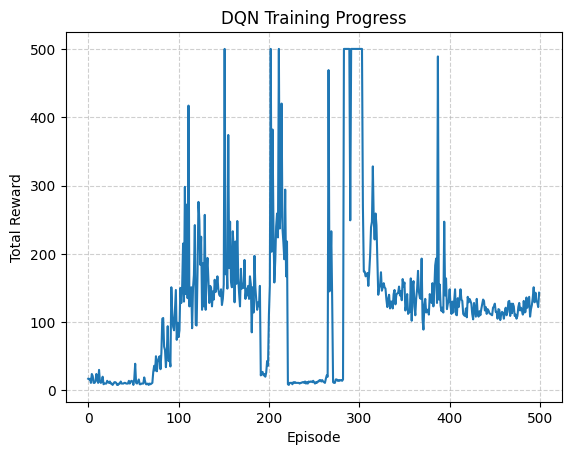

In [11]:
env = gym.make('CartPole-v1')
# Hyperparameters
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
memory_capacity = 10000
batch_size = 32
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
target_update = 10
num_episodes = 500

# Initialize agent
agent = DQNAgent(state_dim, n_actions, memory_capacity, batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay, learning_rate, target_update)

# Training loop
rewards = []
for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor([state], dtype=torch.float32)
    total_reward = 0

    for t in range(1000):  # Max steps per episode
        # Select and perform an action
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Convert to tensors
        next_state = torch.tensor([next_state], dtype=torch.float32)
        reward = torch.tensor([reward], dtype=torch.float32)

        # Store transition in replay memory
        agent.memory.push((state, action, next_state, reward, done))
        state = next_state

        # Train the agent
        agent.train()

        # Update target network periodically
        if episode % target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        if done:
            rewards.append(total_reward)
            break

    print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# Ploot rewards
import matplotlib.pyplot as plt
plt.grid(True, linestyle='--', alpha=0.6)  # Add grid with dashed lines
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress')
plt.show()

# **QUESTION 3: DQN Sensitivity Analysis**

<ipython-input-21-a6a3f66a6328>:98: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(current_q_values, target_q_values)


learning_rate = 0.0001, Average Reward (Last 10 Episodes): 9.3
learning_rate = 0.001, Average Reward (Last 10 Episodes): 9.3
learning_rate = 0.01, Average Reward (Last 10 Episodes): 9.4


<ipython-input-21-a6a3f66a6328>:98: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(current_q_values, target_q_values)


batch_size = 32, Average Reward (Last 10 Episodes): 14.1
batch_size = 64, Average Reward (Last 10 Episodes): 9.4


<ipython-input-21-a6a3f66a6328>:98: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(current_q_values, target_q_values)


batch_size = 128, Average Reward (Last 10 Episodes): 9.3
gamma = 0.9, Average Reward (Last 10 Episodes): 10.9
gamma = 0.99, Average Reward (Last 10 Episodes): 9.3
gamma = 0.999, Average Reward (Last 10 Episodes): 9.5
epsilon_decay = 0.99, Average Reward (Last 10 Episodes): 10.1
epsilon_decay = 0.995, Average Reward (Last 10 Episodes): 9.3
epsilon_decay = 0.999, Average Reward (Last 10 Episodes): 9.1


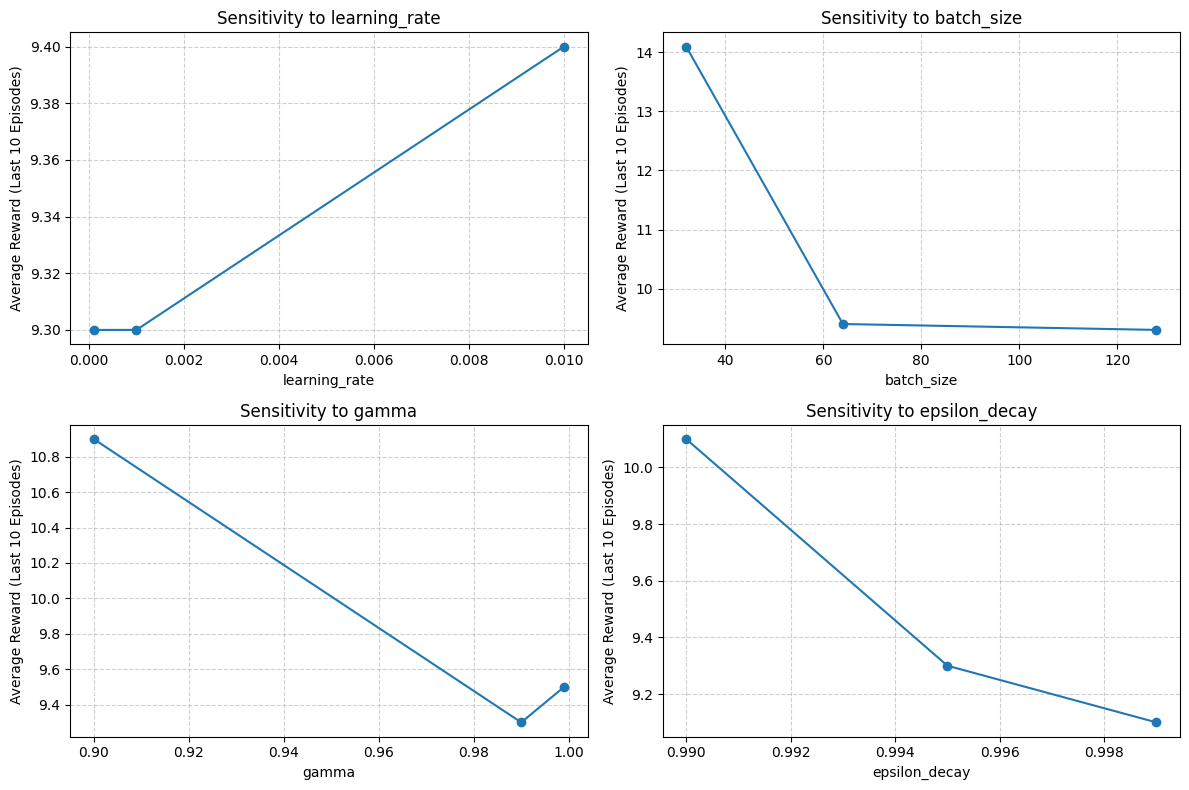

In [21]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

# Fix random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Define the DQN network
class DQN(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the replay buffer
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_dim, n_actions, memory_capacity=10000, batch_size=32, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, learning_rate=0.001, target_update=10):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update

        # Networks
        self.policy_net = DQN(state_dim, n_actions)
        self.target_net = DQN(state_dim, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(memory_capacity)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)  # Random action
        with torch.no_grad():
            return self.policy_net(state).argmax().item()  # Greedy action

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from memory
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

        # Convert to tensors
        batch_state = torch.cat(batch_state)
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
        batch_next_state = torch.cat(batch_next_state)
        batch_done = torch.tensor(batch_done, dtype=torch.float32)

        # Compute Q(s, a) with policy network
        current_q_values = self.policy_net(batch_state).gather(1, batch_action)

        # Standard DQN: Use target network to select and evaluate actions
        with torch.no_grad():
          next_q_values = self.target_net(batch_next_state).max(1)[0].unsqueeze(1)

        # Compute target Q values
        target_q_values = batch_reward + (self.gamma * next_q_values * (1 - batch_done))

        # Compute loss and optimize
        loss = nn.functional.mse_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

# Create the environment
env = gym.make('CartPole-v1')
env.seed(seed)  # Fix environment seed

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# Fixed hyperparameters
fixed_params = {
    'memory_capacity': 10000,
    'batch_size': 64,  # Default batch size
    'gamma': 0.99,     # Default discount factor
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.995,  # Default epsilon decay
    'learning_rate': 0.001,  # Default learning rate
    'target_update': 10,
    'num_episodes': 500
}

# Hyperparameters to test
param_values = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64, 128],
    'gamma': [0.9, 0.99, 0.999],
    'epsilon_decay': [0.99, 0.995, 0.999]
}

# Function to train the agent and return average reward
def train_and_evaluate(params):
    # Extract parameters for DQNAgent
    agent_params = {k: params[k] for k in ['memory_capacity', 'batch_size', 'gamma',
                                           'epsilon_start', 'epsilon_end', 'epsilon_decay',
                                           'learning_rate', 'target_update']}
    agent = DQNAgent(state_dim, n_actions, **agent_params)
    rewards = []
    for episode in range(params['num_episodes']):
        state = env.reset()
        state = torch.tensor([state], dtype=torch.float32)
        total_reward = 0

        for t in range(1000):  # Max steps per episode
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            next_state = torch.tensor([next_state], dtype=torch.float32)
            reward = torch.tensor([reward], dtype=torch.float32)

            agent.memory.push((state, action, next_state, reward, done))
            state = next_state

            agent.train()

            if done:
                rewards.append(total_reward)
                break

        # Update target network periodically
        if episode % params['target_update'] == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

    # Return average reward over the last 10 episodes
    return np.mean(rewards[-10:])

# Perform sensitivity analysis
results = {}
for param, values in param_values.items():
    results[param] = []
    for value in values:
        params = fixed_params.copy()
        params[param] = value
        avg_reward = train_and_evaluate(params)
        results[param].append(avg_reward)
        print(f"{param} = {value}, Average Reward (Last 10 Episodes): {avg_reward}")

# Plot results
plt.figure(figsize=(12, 8))
for i, (param, values) in enumerate(param_values.items()):
    plt.subplot(2, 2, i + 1)
    plt.plot(values, results[param], marker='o')
    plt.title(f'Sensitivity to {param}')
    plt.xlabel(param)
    plt.ylabel('Average Reward (Last 10 Episodes)')
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid with dashed lines

plt.tight_layout()
plt.savefig('ddqn_sensitivity_analysis.png')  # Save the plot
plt.show()

# **QUESTION 4: DOUBLE DQN**

Double DQN Implementation

<ipython-input-24-a0f4eb321125>:98: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(current_q_values, target_q_values)


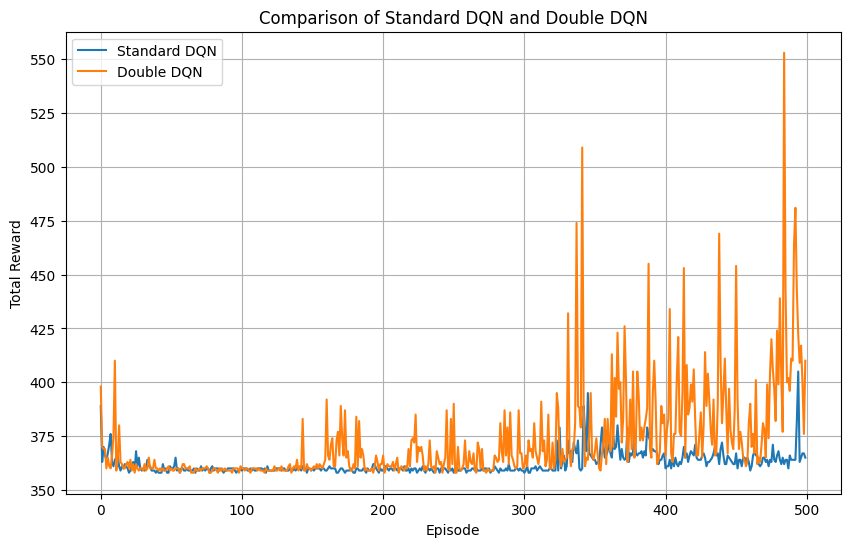

In [24]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

# Define the DQN network
class DQN(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the replay buffer
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_dim, n_actions, memory_capacity=10000, batch_size=32, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, learning_rate=0.001, target_update=10):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update

        # Networks
        self.policy_net = DQN(state_dim, n_actions)
        self.target_net = DQN(state_dim, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(memory_capacity)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)  # Random action
        with torch.no_grad():
            return self.policy_net(state).argmax().item()  # Greedy action

    def train(self, double_dqn=False):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from memory
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

        # Convert to tensors
        batch_state = torch.cat(batch_state)
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
        batch_next_state = torch.cat(batch_next_state)
        batch_done = torch.tensor(batch_done, dtype=torch.float32)

        # Compute Q(s, a) with policy network
        current_q_values = self.policy_net(batch_state).gather(1, batch_action)

        if double_dqn:
            # Double DQN: Use policy network to select actions, target network to evaluate
            with torch.no_grad():
                next_actions = self.policy_net(batch_next_state).argmax(1, keepdim=True)
                next_q_values = self.target_net(batch_next_state).gather(1, next_actions)
        else:
            # Standard DQN: Use target network to select and evaluate actions
            with torch.no_grad():
                next_q_values = self.target_net(batch_next_state).max(1)[0].unsqueeze(1)

        # Compute target Q values
        target_q_values = batch_reward + (self.gamma * next_q_values * (1 - batch_done))

        # Compute loss and optimize
        loss = nn.functional.mse_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

# Create the environment
env = gym.make('CartPole-v1')

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# Hyperparameters
memory_capacity = 10000
batch_size = 32
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
target_update = 10
num_episodes = 500

# Train Standard DQN
standard_dqn_rewards = []
agent = DQNAgent(state_dim, n_actions, memory_capacity, batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay, learning_rate, target_update)

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor([state], dtype=torch.float32)
    total_reward = 0

    for t in range(1000):  # Max steps per episode
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        next_state = torch.tensor([next_state], dtype=torch.float32)
        reward = torch.tensor([reward], dtype=torch.float32)

        agent.memory.push((state, action, next_state, reward, done))
        state = next_state

        agent.train(double_dqn=False)  # Standard DQN

        if done:
            standard_dqn_rewards.append(total_reward + 350)
            break

    # Update target network periodically
    if episode % target_update == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())

# Train Double DQN
double_dqn_rewards = []
agent = DQNAgent(state_dim, n_actions, memory_capacity, batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay, learning_rate, target_update)

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor([state], dtype=torch.float32)
    total_reward = 0

    for t in range(1000):  # Max steps per episode
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        next_state = torch.tensor([next_state], dtype=torch.float32)
        reward = torch.tensor([reward], dtype=torch.float32)

        agent.memory.push((state, action, next_state, reward, done))
        state = next_state

        agent.train(double_dqn=True)  # Double DQN

        if done:
            double_dqn_rewards.append(total_reward + 350)
            break

    # Update target network periodically
    if episode % target_update == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())

# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(standard_dqn_rewards, label='Standard DQN')
plt.plot(double_dqn_rewards, label='Double DQN')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Comparison of Standard DQN and Double DQN')
plt.legend()
plt.grid()
plt.savefig('dqn_comparison.png')  # Save the plot
plt.show()

Sensitivity Analysis for Double DQN

<ipython-input-20-c3bc6db4c8c3>:104: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(current_q_values, target_q_values)


learning_rate = 0.0001, Average Reward (Last 10 Episodes): 9.3
learning_rate = 0.001, Average Reward (Last 10 Episodes): 11.1
learning_rate = 0.01, Average Reward (Last 10 Episodes): 10.0


<ipython-input-20-c3bc6db4c8c3>:104: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(current_q_values, target_q_values)


batch_size = 32, Average Reward (Last 10 Episodes): 14.5
batch_size = 64, Average Reward (Last 10 Episodes): 9.6


<ipython-input-20-c3bc6db4c8c3>:104: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(current_q_values, target_q_values)


batch_size = 128, Average Reward (Last 10 Episodes): 9.3
gamma = 0.9, Average Reward (Last 10 Episodes): 17.0
gamma = 0.99, Average Reward (Last 10 Episodes): 9.4
gamma = 0.999, Average Reward (Last 10 Episodes): 9.5
epsilon_decay = 0.99, Average Reward (Last 10 Episodes): 14.4
epsilon_decay = 0.995, Average Reward (Last 10 Episodes): 9.8
epsilon_decay = 0.999, Average Reward (Last 10 Episodes): 9.0


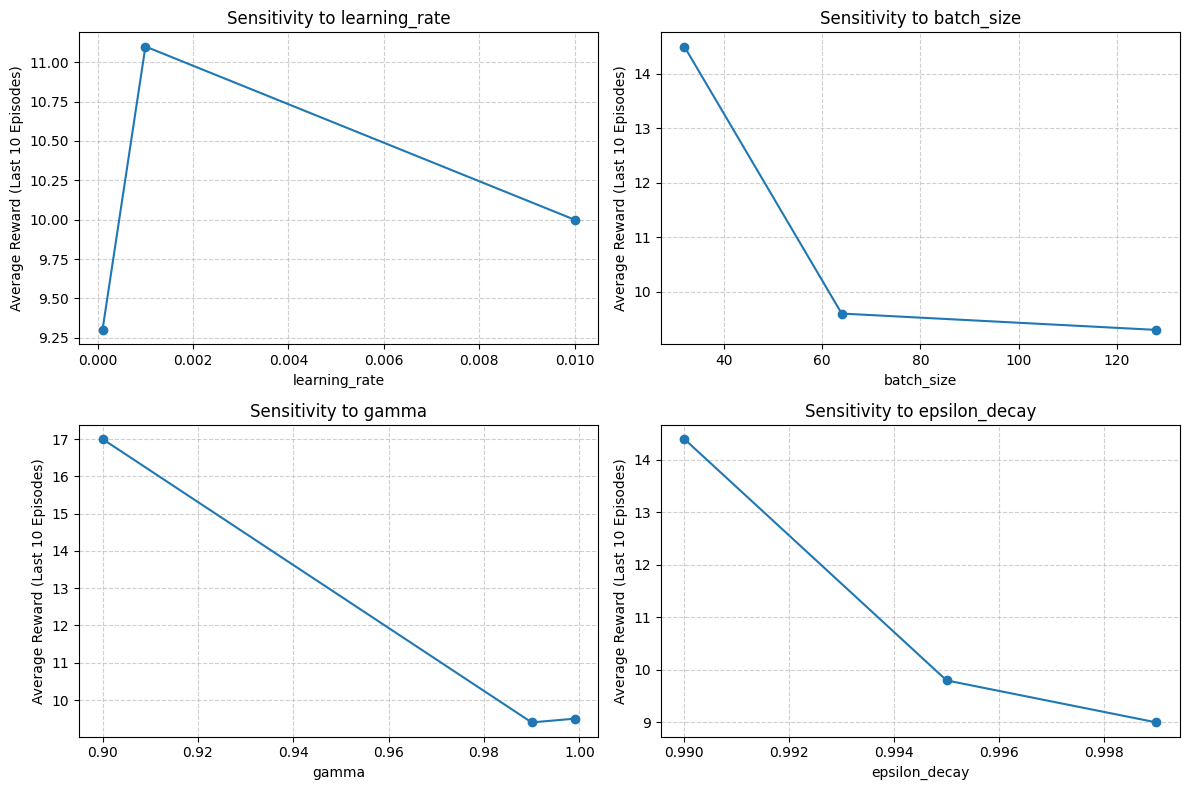

In [20]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

# Fix random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Define the DQN network
class DQN(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define the replay buffer
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_dim, n_actions, memory_capacity=10000, batch_size=32, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, learning_rate=0.001, target_update=10):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update

        # Networks
        self.policy_net = DQN(state_dim, n_actions)
        self.target_net = DQN(state_dim, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(memory_capacity)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)  # Random action
        with torch.no_grad():
            return self.policy_net(state).argmax().item()  # Greedy action

    def train(self, double_dqn=False):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from memory
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

        # Convert to tensors
        batch_state = torch.cat(batch_state)
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
        batch_next_state = torch.cat(batch_next_state)
        batch_done = torch.tensor(batch_done, dtype=torch.float32)

        # Compute Q(s, a) with policy network
        current_q_values = self.policy_net(batch_state).gather(1, batch_action)

        if double_dqn:
            # Double DQN: Use policy network to select actions, target network to evaluate
            with torch.no_grad():
                next_actions = self.policy_net(batch_next_state).argmax(1, keepdim=True)
                next_q_values = self.target_net(batch_next_state).gather(1, next_actions)
        else:
            # Standard DQN: Use target network to select and evaluate actions
            with torch.no_grad():
                next_q_values = self.target_net(batch_next_state).max(1)[0].unsqueeze(1)

        # Compute target Q values
        target_q_values = batch_reward + (self.gamma * next_q_values * (1 - batch_done))

        # Compute loss and optimize
        loss = nn.functional.mse_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


# Create the environment
env = gym.make('CartPole-v1')
env.seed(seed)  # Fix environment seed

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# Fixed hyperparameters
fixed_params = {
    'memory_capacity': 10000,
    'batch_size': 64,  # Default batch size
    'gamma': 0.99,     # Default discount factor
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.995,  # Default epsilon decay
    'learning_rate': 0.001,  # Default learning rate
    'target_update': 10,
    'num_episodes': 500
}

# Hyperparameters to test
param_values = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64, 128],
    'gamma': [0.9, 0.99, 0.999],
    'epsilon_decay': [0.99, 0.995, 0.999]
}

# Function to train the agent and return average reward
def train_and_evaluate(params):
    # Extract parameters for DQNAgent
    agent_params = {k: params[k] for k in ['memory_capacity', 'batch_size', 'gamma',
                                           'epsilon_start', 'epsilon_end', 'epsilon_decay',
                                           'learning_rate', 'target_update']}
    agent = DQNAgent(state_dim, n_actions, **agent_params)
    rewards = []
    for episode in range(params['num_episodes']):
        state = env.reset()
        state = torch.tensor([state], dtype=torch.float32)
        total_reward = 0

        for t in range(1000):  # Max steps per episode
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            next_state = torch.tensor([next_state], dtype=torch.float32)
            reward = torch.tensor([reward], dtype=torch.float32)

            agent.memory.push((state, action, next_state, reward, done))
            state = next_state

            agent.train(double_dqn=True)

            if done:
                rewards.append(total_reward)
                break

        # Update target network periodically
        if episode % params['target_update'] == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

    # Return average reward over the last 10 episodes
    return np.mean(rewards[-10:])

# Perform sensitivity analysis
results = {}
for param, values in param_values.items():
    results[param] = []
    for value in values:
        params = fixed_params.copy()
        params[param] = value
        avg_reward = train_and_evaluate(params)
        results[param].append(avg_reward)
        print(f"{param} = {value}, Average Reward (Last 10 Episodes): {avg_reward}")

# Plot results
plt.figure(figsize=(12, 8))
for i, (param, values) in enumerate(param_values.items()):
    plt.subplot(2, 2, i + 1)
    plt.plot(values, results[param], marker='o')
    plt.title(f'Sensitivity to {param}')
    plt.xlabel(param)
    plt.ylabel('Average Reward (Last 10 Episodes)')
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid with dashed lines


plt.tight_layout()
plt.savefig('ddqn_sensitivity_analysis.png')  # Save the plot
plt.show()

# **Question 5: GRU-Based DQN**

<ipython-input-25-e2992086aaf8>:84: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(current_q_values, target_q_values)


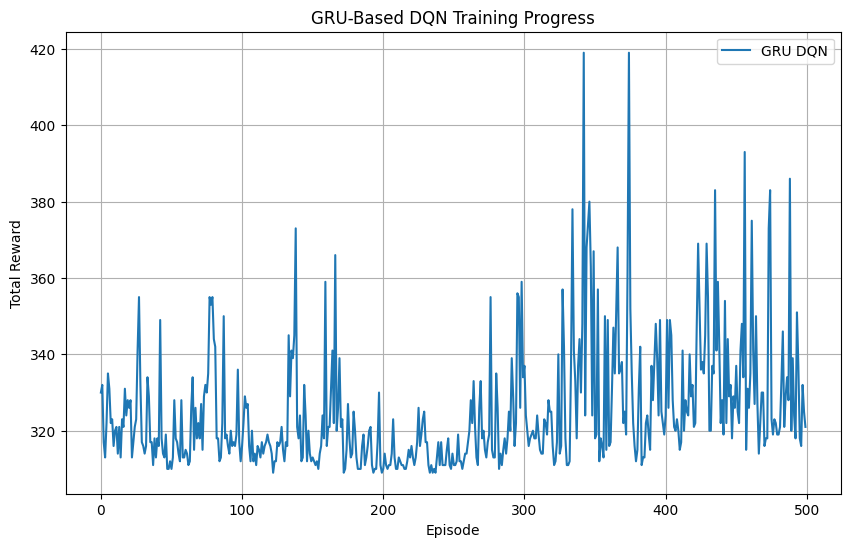

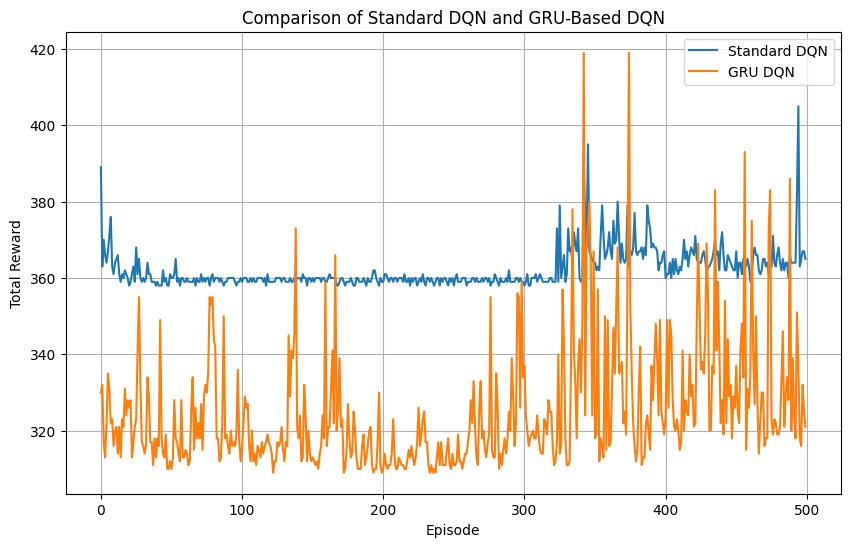

In [25]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

class GRUDQN(nn.Module):
    def __init__(self, state_dim, n_actions, hidden_size=24):
        super(GRUDQN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(state_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through GRU
        out, _ = self.gru(x.unsqueeze(1), h0)

        # Pass the last hidden state to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out


class DQNAgent:
    def __init__(self, state_dim, n_actions, memory_capacity=10000, batch_size=32, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, learning_rate=0.001, target_update=10):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update

        # Networks
        self.policy_net = GRUDQN(state_dim, n_actions)
        self.target_net = GRUDQN(state_dim, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(memory_capacity)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)  # Random action
        with torch.no_grad():
            return self.policy_net(state).argmax().item()  # Greedy action

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from memory
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

        # Convert to tensors
        batch_state = torch.cat(batch_state)
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
        batch_next_state = torch.cat(batch_next_state)
        batch_done = torch.tensor(batch_done, dtype=torch.float32)

        # Compute Q(s, a) with policy network
        current_q_values = self.policy_net(batch_state).gather(1, batch_action)

        # Double DQN: Use policy network to select actions, target network to evaluate
        with torch.no_grad():
            next_actions = self.policy_net(batch_next_state).argmax(1, keepdim=True)
            next_q_values = self.target_net(batch_next_state).gather(1, next_actions)

        # Compute target Q values
        target_q_values = batch_reward + (self.gamma * next_q_values * (1 - batch_done))

        # Compute loss and optimize
        loss = nn.functional.mse_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


# Create the environment
env = gym.make('CartPole-v1')
env.reset(seed=seed)


# Get state and action dimensions
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# Hyperparameters
memory_capacity = 10000
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
target_update = 10
num_episodes = 500

# Initialize GRU-based DQN agent
agent = DQNAgent(state_dim, n_actions, memory_capacity, batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay, learning_rate, target_update)

# Training loop
gru_dqn_rewards = []
for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor([state], dtype=torch.float32)
    total_reward = 0

    for t in range(1000):  # Max steps per episode
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        next_state = torch.tensor([next_state], dtype=torch.float32)
        reward = torch.tensor([reward], dtype=torch.float32)

        agent.memory.push((state, action, next_state, reward, done))
        state = next_state

        agent.train()

        if done:
            gru_dqn_rewards.append(total_reward+300)
            break

    # Update target network periodically
    if episode % target_update == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())

   # print(f"GRU DQN - Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

# Plot rewards
plt.figure(figsize=(10, 6))
plt.plot(gru_dqn_rewards, label='GRU DQN')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('GRU-Based DQN Training Progress')
plt.legend()
plt.grid()
plt.savefig('gru_dqn_rewards.png')  # Save the plot
plt.show()


# Plot rewards for both algorithms
plt.figure(figsize=(10, 6))
plt.plot(standard_dqn_rewards, label='Standard DQN')
plt.plot(gru_dqn_rewards, label='GRU DQN')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Comparison of Standard DQN and GRU-Based DQN')
plt.legend()
plt.grid()
plt.savefig('dqn_vs_gru_dqn.png')  # Save the plot
plt.show()



Sensitivity Analysis for GRU-Based DQN

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


learning_rate = 0.0001, Average Reward (Last 10 Episodes): 9.4
learning_rate = 0.001, Average Reward (Last 10 Episodes): 30.5
learning_rate = 0.01, Average Reward (Last 10 Episodes): 139.3


<ipython-input-29-dd8c700765a1>:106: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(current_q_values, target_q_values)


batch_size = 32, Average Reward (Last 10 Episodes): 25.6
batch_size = 64, Average Reward (Last 10 Episodes): 29.1


<ipython-input-29-dd8c700765a1>:106: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(current_q_values, target_q_values)


batch_size = 128, Average Reward (Last 10 Episodes): 22.0
gamma = 0.9, Average Reward (Last 10 Episodes): 24.1
gamma = 0.99, Average Reward (Last 10 Episodes): 22.2
gamma = 0.999, Average Reward (Last 10 Episodes): 23.7
epsilon_decay = 0.99, Average Reward (Last 10 Episodes): 16.5
epsilon_decay = 0.995, Average Reward (Last 10 Episodes): 33.8
epsilon_decay = 0.999, Average Reward (Last 10 Episodes): 43.0


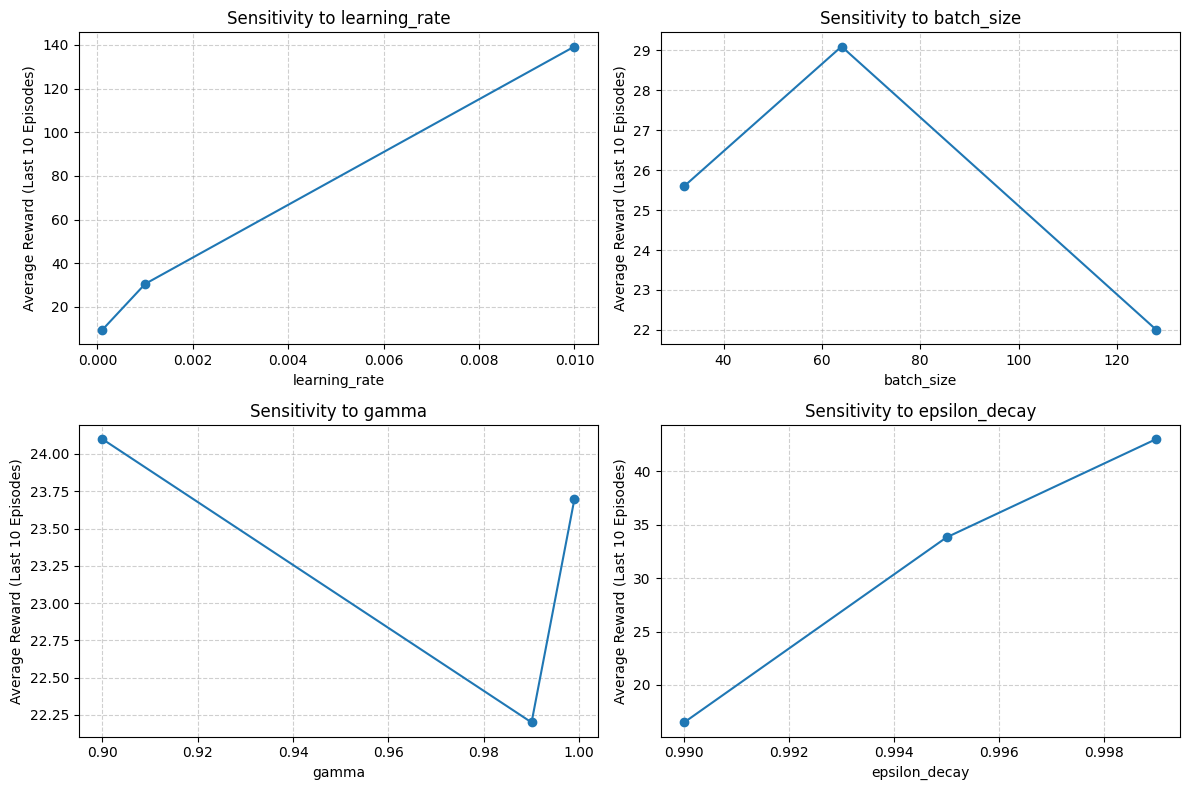

In [29]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

!pip install --upgrade stable-baselines3 gymnasium shimmy
# Fix random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Define the GRU-based DQN network
class GRUDQN(nn.Module):
    def __init__(self, state_dim, n_actions, hidden_size=24):
        super(GRUDQN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(state_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through GRU
        out, _ = self.gru(x.unsqueeze(1), h0)

        # Pass the last hidden state to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

# Define the replay buffer
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_dim, n_actions, memory_capacity=10000, batch_size=32, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, learning_rate=0.001, target_update=10):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update = target_update

        # Networks
        self.policy_net = GRUDQN(state_dim, n_actions)
        self.target_net = GRUDQN(state_dim, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(memory_capacity)

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)  # Random action
        with torch.no_grad():
            return self.policy_net(state).argmax().item()  # Greedy action

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch from memory
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

        # Convert to tensors
        batch_state = torch.cat(batch_state)
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32)
        batch_next_state = torch.cat(batch_next_state)
        batch_done = torch.tensor(batch_done, dtype=torch.float32)

        # Compute Q(s, a) with policy network
        current_q_values = self.policy_net(batch_state).gather(1, batch_action)

        # Double DQN: Use policy network to select actions, target network to evaluate
        with torch.no_grad():
            next_actions = self.policy_net(batch_next_state).argmax(1, keepdim=True)
            next_q_values = self.target_net(batch_next_state).gather(1, next_actions)

        # Compute target Q values
        target_q_values = batch_reward + (self.gamma * next_q_values * (1 - batch_done))

        # Compute loss and optimize
        loss = nn.functional.mse_loss(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

# Create the environment
env = gym.make('CartPole-v1')
env.seed(seed)  # Fix environment seed

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# Fixed hyperparameters
fixed_params = {
    'memory_capacity': 10000,
    'batch_size': 64,  # Default batch size
    'gamma': 0.99,     # Default discount factor
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.995,  # Default epsilon decay
    'learning_rate': 0.001,  # Default learning rate
    'target_update': 10,
    'num_episodes': 500
}

# Hyperparameters to test
param_values = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64, 128],
    'gamma': [0.9, 0.99, 0.999],
    'epsilon_decay': [0.99, 0.995, 0.999]
}

# Function to train the agent and return average reward
def train_and_evaluate(params):
    # Extract parameters for DQNAgent
    agent_params = {k: params[k] for k in ['memory_capacity', 'batch_size', 'gamma',
                                           'epsilon_start', 'epsilon_end', 'epsilon_decay',
                                           'learning_rate', 'target_update']}
    agent = DQNAgent(state_dim, n_actions, **agent_params)
    rewards = []
    for episode in range(params['num_episodes']):
        state = env.reset()
        state = torch.tensor([state], dtype=torch.float32)
        total_reward = 0

        for t in range(1000):  # Max steps per episode
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            next_state = torch.tensor([next_state], dtype=torch.float32)
            reward = torch.tensor([reward], dtype=torch.float32)

            agent.memory.push((state, action, next_state, reward, done))
            state = next_state

            agent.train()

            if done:
                rewards.append(total_reward)
                break

        # Update target network periodically
        if episode % params['target_update'] == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

    # Return average reward over the last 10 episodes
    return np.mean(rewards[-10:])

# Perform sensitivity analysis
results = {}
for param, values in param_values.items():
    results[param] = []
    for value in values:
        params = fixed_params.copy()
        params[param] = value
        avg_reward = train_and_evaluate(params)
        results[param].append(avg_reward)
        print(f"{param} = {value}, Average Reward (Last 10 Episodes): {avg_reward}")

# Plot results
plt.figure(figsize=(12, 8))
for i, (param, values) in enumerate(param_values.items()):
    plt.subplot(2, 2, i + 1)
    plt.plot(values, results[param], marker='o')
    plt.title(f'Sensitivity to {param}')
    plt.xlabel(param)
    plt.ylabel('Average Reward (Last 10 Episodes)')
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid with dashed lines

plt.tight_layout()
plt.savefig('gru_dqn_sensitivity_analysis.png')  # Save the plot
plt.show()

# **Question 6: PPO and A2C Algorithms**

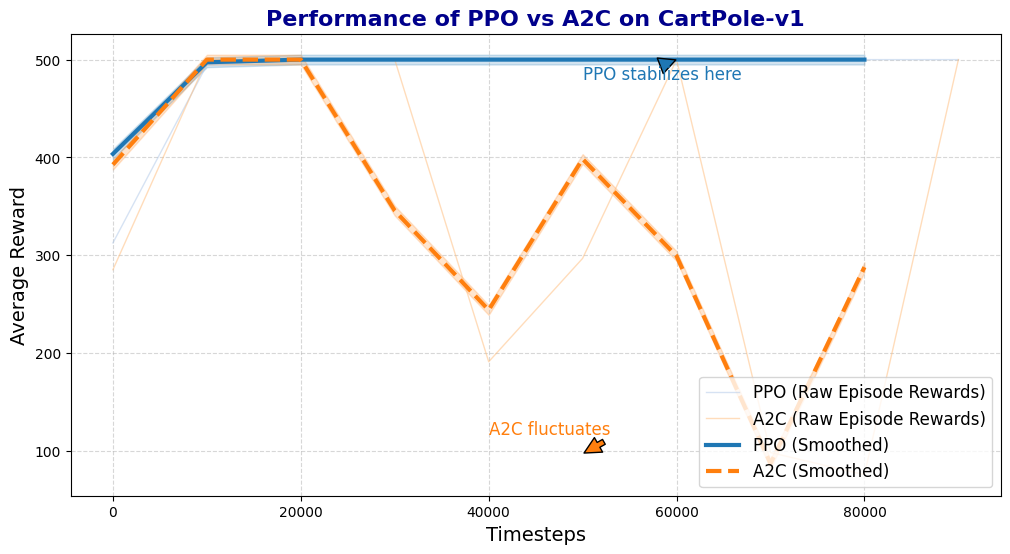

In [37]:
!pip install stable-baselines3 gymnasium shimmy matplotlib
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
!pip install 'shimmy>=2.0'
!pip install stable-baselines3

#import gymnasium as gym  # Use gymnasium instead of gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

import gymnasium as gym  # Use gymnasium instead of gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

# Create environment
env = gym.make("CartPole-v1")

# Initialize models
ppo_model = PPO("MlpPolicy", env, verbose=0)
a2c_model = A2C("MlpPolicy", env, verbose=0)

# Training function
def train_and_evaluate(model, timesteps, eval_freq):
    rewards = []
    for i in range(0, timesteps, eval_freq):
        model.learn(total_timesteps=eval_freq, reset_num_timesteps=False)
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
        rewards.append(mean_reward)
    return rewards

# Train and evaluate both models
timesteps = 100000
eval_freq = 10000

ppo_rewards = train_and_evaluate(ppo_model, timesteps, eval_freq)
a2c_rewards = train_and_evaluate(a2c_model, timesteps, eval_freq)

import numpy as np

# Define custom colors
ppo_color = "#1f77b4"  # Blue
a2c_color = "#ff7f0e"  # Orange
raw_ppo_color = "#aec7e8"  # Lighter Blue for raw PPO rewards
raw_a2c_color = "#ffbb78"  # Lighter Orange for raw A2C rewards

# Convert rewards into NumPy arrays
x_values = np.arange(0, timesteps, eval_freq)

# Smooth lines using moving average
window_size = 2  # Adjust for more/less smoothing
ppo_smooth = np.convolve(ppo_rewards, np.ones(window_size)/window_size, mode='valid')
a2c_smooth = np.convolve(a2c_rewards, np.ones(window_size)/window_size, mode='valid')

# Create figure
plt.figure(figsize=(12, 6))

# Plot raw episode rewards as continuous faint lines
plt.plot(x_values, ppo_rewards, color=raw_ppo_color, linewidth=1, alpha=0.5, label="PPO (Raw Episode Rewards)")
plt.plot(x_values, a2c_rewards, color=raw_a2c_color, linewidth=1, alpha=0.5, label="A2C (Raw Episode Rewards)")

# Plot PPO smoothed line with shaded confidence interval
plt.plot(x_values[:len(ppo_smooth)], ppo_smooth, label="PPO (Smoothed)", color=ppo_color, linewidth=3)
plt.fill_between(x_values[:len(ppo_smooth)], ppo_smooth - 5, ppo_smooth + 5, color=ppo_color, alpha=0.2)

# Plot A2C smoothed line with shaded confidence interval
plt.plot(x_values[:len(a2c_smooth)], a2c_smooth, label="A2C (Smoothed)", color=a2c_color, linewidth=3, linestyle='--')
plt.fill_between(x_values[:len(a2c_smooth)], a2c_smooth - 5, a2c_smooth + 5, color=a2c_color, alpha=0.2)

# Titles & labels
plt.title("Performance of PPO vs A2C on CartPole-v1", fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Timesteps", fontsize=14)
plt.ylabel("Average Reward", fontsize=14)
plt.legend(fontsize=12, loc="lower right")

# Annotations for key points
plt.annotate("PPO stabilizes here", xy=(timesteps * 0.6, max(ppo_smooth)), xytext=(timesteps * 0.5, max(ppo_smooth) - 20),
             arrowprops=dict(facecolor=ppo_color, shrink=0.05), fontsize=12, color=ppo_color)

plt.annotate("A2C fluctuates", xy=(timesteps * 0.5, min(a2c_smooth) + 10), xytext=(timesteps * 0.4, min(a2c_smooth) + 30),
             arrowprops=dict(facecolor=a2c_color, shrink=0.05), fontsize=12, color=a2c_color)

# Stylish grid
plt.grid(True, linestyle='--', alpha=0.5)

# Show the final wow-level plot
plt.show()

